In [18]:
# Add analysis to the path
import sys
import pathlib
import os

parent_dir = os.path.join(os.path.abspath(''), "..")
sys.path.append(parent_dir)

import parsers
from multiprocessing import Pool, cpu_count
from pprint import pprint
from aggregation import *
import numpy
import pandas
import matplotlib.pyplot as plt
from matplotlib import rc
from pprint import pprint, pformat

rc('font',**{'family': 'serif', 'size': 19})
rc('text', usetex=True)

path_to_results = os.path.normpath(os.path.join(parent_dir, "archive"))
print(path_to_results)
working_dir = os.path.normpath(os.path.join(parent_dir, "working"))
data = parsers.main(path_to_results, working_dir=working_dir)
print("Finished")

/home/jazev/dev/cs4365/analysis/archive
Extracting 30 top level archives on 4 workers
Finished


In [2]:
import csv
import numpy
import sys
import pandas as pd

class LogEntry:
    
    def __init__(self, event, ts, sock_fd):
        self._event = event
        self._ts = ts
        self._sock_fd = sock_fd
    
    def __lt__(self, other):
        return self._ts < other._ts
    
    def event(self):
        return self._event
    
    def ts(self):
        return self._ts
    
    def sock_fd(self):
        return self._sock_fd
    
    def __repr__(self):
        return "[{event} -- TS: {ts}; SOCK_FD: {sock_fd}]".format(event=self._event, ts=str(self._ts), sock_fd=str(self._sock_fd))
    
def aggregate(test_name, rep_num):
    recvfrom = data.get(test_name).replicas[rep_num].hosts["client"].recvfrom()
    sendto = data.get(test_name).replicas[rep_num].hosts["client"].sendto()
    connect = data.get(test_name).replicas[rep_num].hosts["client"].connect()
    

def aggregate(replica):
    recvfrom = replica.hosts["client"].recvfrom()
    sendto = replica.hosts["client"].sendto()
    connect = replica.hosts["client"].connect()

    log_entries = []
    for i in range(len(connect)):
        if int(connect[i].port()) == 80:
            log_entries.append(LogEntry("connect", int(connect[i].ts()), int(connect[i].sock_fd())))

    for i in range(len(sendto)):     
        log_entries.append(LogEntry("sendto", int(sendto[i].ts()), int(sendto[i].sock_fd())))

    for i in range(len(recvfrom)):   
        log_entries.append(LogEntry("recvfrom", int(recvfrom[i].ts()), int(recvfrom[i].sock_fd())))

    log_entries.sort()
    requests = []
    for i in range(len(log_entries)):
        if log_entries[i].event() == "connect":
            request = [log_entries[i]]
            j = i + 1
            while j < len(log_entries) and(log_entries[j].event() != "connect"or log_entries[i].sock_fd() != log_entries[j].sock_fd()):
                if log_entries[i].sock_fd() == log_entries[j].sock_fd():
                    request.append(log_entries[j])
                j += 1
            requests.append(request)

    if not requests:
        print(f"warning: replica {replica.id} for test {replica.test_id} had no recorded requests")
        times = []
        rt = []
    else:
        rt_dist = [((request[0].ts() / 1E3, (request[-1].ts() - request[0].ts()) / 1E3)) for request in requests]
        times, rt = zip(*rt_dist)
    return pd.DataFrame({'ts': times, 'rt': rt})

In [3]:
dic = {}
for test in data.values():
    if "ii-" not in test.id:
        continue
    print(f"analyzing test {test.id}")
    df = None
    with Pool(cpu_count()) as pool:
        for sub_df in pool.imap_unordered(aggregate, test.replicas):
            if df is None:
                df = sub_df
            else:
                df.append(sub_df)
    print(f"  done with test {test.id}")
    dic[test.id] = df
print("done")

analyzing test ii-c-b
  done with test ii-c-b
analyzing test ii-rc-s
  done with test ii-rc-s
analyzing test ii-m-s
  done with test ii-m-s
analyzing test ii-r-s
  done with test ii-r-s
analyzing test ii-mc-b
  done with test ii-mc-b
analyzing test ii-c-s
  done with test ii-c-s
analyzing test ii-r-b
  done with test ii-r-b
analyzing test ii-m-b
  done with test ii-m-b
analyzing test ii-rc-b
  done with test ii-rc-b
analyzing test ii-mc-s
  done with test ii-mc-s
done


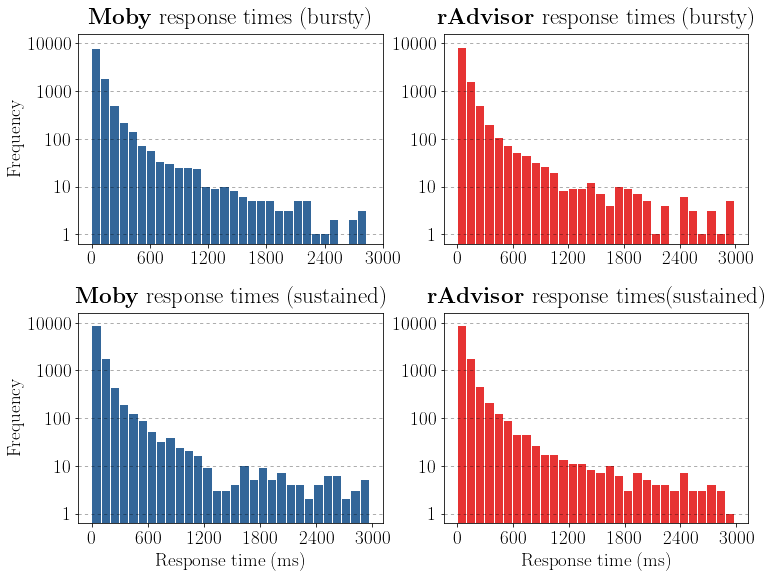

In [40]:
import matplotlib.ticker as mticker



def plot_response_times(test, axes_labels, title, color='blue', ax=None):
    rt = [r for r in dic[test]['rt'] if r < 3000]
    # this was chosen arbitrarily by adjusting until bars looked good
    bar_width = 0.89

    ax = ax or plt.gca()
    ticks = [1, 10, 100, 1000, 10000]
    for t in ticks:
        ax.axhline(y=t, color='black', linestyle='dashed', alpha=0.4, lw=0.8, dashes=[4, 4])

    ax.set_title(title, pad=10)
    ax.hist(rt, bins=30, rwidth=0.89, color=color)
    ax.set_yscale('log')
    if axes_labels[0]:
        ax.set_ylabel("Frequency")
    if axes_labels[1]:
        ax.set_xlabel("Response time (ms)")
    ax.xaxis.labelpad = 5
    ax.set_yticks(ticks)
    ax.set_xticks([0, 600, 1200, 1800, 2400, 3000])
    ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())

color_a = (0.2, 0.4, 0.6)
color_b = (0.9, 0.2, 0.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.33)
plot_response_times("ii-m-b",  (True, False),  "\\textbf{Moby} response times (bursty)",       color=color_a, ax=ax1)
plot_response_times("ii-r-b",  (False, False), "\\textbf{rAdvisor} response times (bursty)",   color=color_b, ax=ax2)
plot_response_times("ii-m-s",  (True, True),   "\\textbf{Moby} response times (sustained)",    color=color_a, ax=ax3)
plot_response_times("ii-r-s",  (False, True),  "\\textbf{rAdvisor} response times(sustained)", color=color_b, ax=ax4)
plt.savefig('response_times.pdf', bbox_inches='tight')

ax = plt.gca()
plt.show()

In [48]:
for key, df in dic.items():
    print(key)
    rt = df['rt']
    print(f"n: {len(rt)}")
    print(f"25% percentile: {np.percentile(rt, 25)}")
    print(f"50% percentile: {np.percentile(rt, 50)}")
    print(f"75% percentile: {np.percentile(rt, 75)}")
    print(f"90% percentile: {np.percentile(rt, 90)}")
    print("=============================================")

ii-c-b
n: 10819
25% percentile: 34.2805
50% percentile: 58.724
75% percentile: 100.505
90% percentile: 214.13720000000018
ii-rc-s
n: 11370
25% percentile: 35.438500000000005
50% percentile: 59.4525
75% percentile: 103.185
90% percentile: 206.8123000000001
ii-m-s
n: 11221
25% percentile: 36.065
50% percentile: 60.089
75% percentile: 100.749
90% percentile: 201.211
ii-r-s
n: 11308
25% percentile: 35.146
50% percentile: 59.3775
75% percentile: 101.65725
90% percentile: 206.61190000000073
ii-mc-b
n: 10836
25% percentile: 34.683499999999995
50% percentile: 57.9065
75% percentile: 101.2365
90% percentile: 219.4955
ii-c-s
n: 11292
25% percentile: 35.76275
50% percentile: 59.044
75% percentile: 101.02275
90% percentile: 207.11249999999995
ii-r-b
n: 10719
25% percentile: 33.653999999999996
50% percentile: 57.735
75% percentile: 100.6465
90% percentile: 215.58740000000014
ii-m-b
n: 10800
25% percentile: 33.867999999999995
50% percentile: 57.5715
75% percentile: 103.545
90% percentile: 209.702200